Uncertainty for Deep Learning

## Uncertainty in Deep Learning 
As deep learning being widely applied in both scientific and industrial fields such as physics, biology, medication and manufacturing where a small error of model prediction can cause severe consequences, representing model uncertainty is of crucial importance. In gerenal, deep learning models are overconfident about their outputs. In most classification problems, models output predictive probabilities by applying a softmax/sigmoid activation function at the output layer which are often erroneously interpreted as model confidence. Whereas most regression models output the prediction and trying to match it with the true label (a deterministic function). \\

There are several methods which can be served as model variance (uncertainty) estimation tools mentioned in previous chapters, including cross validation, bootstrap sampling, leave-one-out cross validation, Jackknife and Jackknife+. Cross valiaditon, bootstrap sampling and leave-one-out cross validation could be used to estimate variation of weights by go through the test dataset across different weights. Jackknife+ is more focusing on estimating population parameters (eg. outputs from the neural network) and their standards errors. In a more practical perspective, cross-validation methods compute a statistic on the left-out samples. Most often, they predict the left-out samples by a model built on the kept samples. While jackknifing methods compute a statistic from the kept samples only. All these methods perform uncertainty estimation statistically and they are not predictive. \\
On the other hand, deep generative models like variational autoencode (VAE) and normalizing flow are able to predict a distribution which could also get uncertainty over prediction. \\

In this chapter, we are focusing on methods being used in deep learning which are able to give predictive uncertainty. \\


## Why we need uncertainty for Deep Learning 
"All models are wrong, but models that know when they are wrong, are useful." <br>

Good uncertainty estimates quantify when we can trust the model’s predictions. The probabilistic view of machine learning offers confidence bounds for data analysis and decision making.


## Aleatoric Uncertainty vs Epistemic Uncertainty
Aleatoric uncertainty is also known as data uncertainty or statistical uncertainty. It arises from the unpredictable, random nature of the physical system under study. For example, data collected from an actual chemical experiment must contains the influence of temperature fluctuation, instrumental error, etc. It couldn't be reduced. In deep learning, the uncertainty arised from data could be passed to the predictions. <br>
Epistemic uncertainty is also known as model uncertainty or system uncertainty. It arises from the lack of knowledge of the system in respect to quantities and processes within the system. For example, ***It can be reduced through more comprehensive study. 
As opposed to uncertainty caused by randomness, uncertainty
caused by ignorance can in principle be reduced on the basis of additional information. 

## Active Learning / Bayesian Optimization
Uncertainty could be used in machine learning piplines and optimization procedures. In workflows of Active Learning (AL) and Bayesian Optimization (BO), uncertainty serves as an instructional role to guide the systems accomplishing their decision making in each step. In Active Learning, the objective is to select the most informative observations for updating an existing model for future predictions based on the predictive uncertainty of the current model. Whereas in Bayesian Optimization, the objective is to select and gather the most informative observations for finding the global maximum of a blackbox function modeled by a surrogate model. The informativeness measure are defined using an improvement-based (e.g. probability of improvement or expected improvement), entropy-based, or upper confidence bound (UCB) acquisition function, where the uncertainty of the surrogate model is required. 
***
a figure
***

## Drop Out
Dropout is conventionally used during the training phase as regularization method which is able to prevent the model from overfitting. It works by randomly setting the outgoing edges of hidden units to 0 at each update of the training phase. It is seen as a regularization method since it also pushes the weights towards zero (though randomly). In this chapter, we focus on how dropout can be used to obtain the uncertainty of inference. In https://arxiv.org/pdf/1506.02142.pdf, they pointed out doing drop out is equivalent with doing Gaussian Process Regression (GPR)


## Calibration
toolbox

```
# This is formatted as code
```


In [ ]:
import pandas as pd
import numpy as np

## Load Data

In [ ]:
# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
soldata.head()

features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]
features = soldata.loc[:, feature_names].values
labels = soldata.Solubility.values

feature_dim = features.shape[1]

# standardize features
fstd = np.std(features, axis=0)
fmean = np.mean(features, axis=0)
features = (features - fmean) / fstd

In [ ]:
!pip install -U dm-haiku
!pip install distrax
!pip install optax

In [ ]:
# bayesian neural network
import jax
import jax.numpy as jnp
import haiku as hk
import distrax
import optax

## Bayesian Neural Network
Bayesian neural network (BNN) usually refers to neural network that is trained using Bayesian approach. It can be seen as doing regularization by adding uncertainty to network weights, or predicting using an ensemble of infinite number of networks following certain weight distribution. In a traditional neural network, weights are assigned as a single value or point estimate, whereas in a BNN, weights are considered a probability distribution. In forward steps, weights are sampled from a set of normal distributions which contains means and standard deviations for all neurons. During training, the set of distributions are updated by backpropagation using reparameterization trick. 
***
Equation for reparameterization trick
***
a sketch figure
***

In [ ]:
class BNNLayer(hk.Module):
  """
    Bayesian neural network single layer
  """
  def __init__(self, output_dim, name=None, prior_var=10.0):
    super().__init__(name=name)
    self.prior_var = prior_var
    self.output_dim = output_dim

  def __call__(self, x):
    key = hk.next_rng_key()
    w_key, b_key = jax.random.split(key, num=2)
    w_mu = jnp.zeros((x.shape[-1], self.output_dim))
    w_rho = jnp.zeros((x.shape[-1], self.output_dim))
    b_mu = jnp.zeros(self.output_dim)
    b_rho = jnp.zeros(self.output_dim)
    prior = distrax.Normal(0., self.prior_var)
    # sample weights
    w_epsilon = jax.random.normal(key, w_mu.shape)
    w = w_mu + jnp.log(1 + jnp.exp(w_rho)) * w_epsilon

    # sample bias
    b_epsilon = jax.random.normal(key, b_mu.shape)
    b = b_mu + jnp.log(1 + jnp.exp(b_rho)) * b_epsilon

    # record log prior by evaluating log pdf at sampled weight and bias
    self.w_log_prior = prior.log_prob(w)
    self.b_log_prior = prior.log_prob(b)
    self.log_prior = jnp.sum(self.w_log_prior) + jnp.sum(self.b_log_prior)

    # record log variational posterior by evaluating log pdf of normal distribution
    self.w_post = distrax.Normal(w_mu, jnp.log(1 + jnp.exp(w_rho)))
    self.b_post = distrax.Normal(b_mu, jnp.log(1 + jnp.exp(b_rho)))
    self.log_post = jnp.sum(self.w_post.log_prob(w)) + jnp.sum(self.b_post.log_prob(b))

    w_ = hk.get_parameter("w", shape=w.shape, dtype=x.dtype, init=hk.initializers.Constant(w))
    b_ = hk.get_parameter("b", shape=b.shape, dtype=x.dtype, init=hk.initializers.Constant(b))
    
    return jnp.dot(x, w_) + b_

In [ ]:
class BNN_MLP(hk.Module):
  def __init__(self, noise_tol=.1):

    # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
    super().__init__()
    self.noise_tol = noise_tol

  def __call__(self, x):
    # This is equivalent to a standard multilayer perceptron
    self.hidden = BNNLayer(32)
    self.out = BNNLayer(1)
    x = jax.nn.relu(self.hidden(x))
    x = self.out(x)
    return x

def ELBO(posterior, x, y, sample_num):
  params = distrax.Normal(posterior)
  outputs = jnp.zeros((sample_num, y.shape[0]))
  log_priors = jnp.zeros(sample_num)
  log_posts = jnp.zeros(sample_num)
  log_likes = jnp.zeros(sample_num)
  # make predictions and calculate prior, posterior, and likelihood for a given number of samples
  for i in range(sample_num):
    mlp = BNN_MLP()
    outputs = outputs.at[i].set(mlp(x).reshape(-1)) # make predictions
    log_priors = log_priors.at[i].set(mlp.hidden.log_prior + mlp.out.log_prior) # get log prior
    log_posts = log_posts.at[i].set(mlp.hidden.log_post + mlp.out.log_post) # get log variational posterior
    log_likes = log_likes.at[i].set(jnp.sum(distrax.Normal(outputs[i], mlp.noise_tol).log_prob(y.reshape(-1)))) # calculate the log likelihood
    # calculate monte carlo estimate of prior posterior and likelihood
  log_prior = jnp.mean(log_priors)
  log_post = jnp.mean(log_posts)
  log_like = jnp.mean(log_likes)
  # calculate the negative elbo (which is our loss function)
  loss = log_post - log_prior - log_like
  return loss

  

In [ ]:
def toy_function(x):
    return -x**4 + 3*x**2 + 1

x = jnp.array([-2, -1.8, -1, 1, 1.8, 2]).reshape(-1,1)
y = toy_function(x)

elbo = hk.transform(ELBO)
key = jax.random.PRNGKey(0)
params = elbo.init(key, x, y, 10)
prior = dict(
    mu = params, 
    var = jax.tree_map(lambda x: -7 * jnp.ones_like(x), params),
)

loss_fun = elbo.apply

In [ ]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation, inputs, labels, key) -> optax.Params:
  opt_state = optimizer.init(params)

  #@jax.jit
  def step(params, opt_state, inputs, labels, key):
    loss_value, grads = jax.value_and_grad(loss_fun)(params, key, inputs, labels, 10)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for epoch in range(100):
    for i, (input, label) in enumerate(zip(inputs, labels)):
      params, opt_state, loss_value = step(params, opt_state, inputs, labels, next(key))
    if epoch % 10 == 0:
      print(f'epoch {epoch}, loss: {loss_value}')

  return params

In [ ]:
optimizer = optax.adam(learning_rate=1e-2)
params = fit(params, optimizer, x, y, key)

epoch 0, loss: 2371.658935546875
epoch 10, loss: 756.49609375
epoch 20, loss: 519.6778564453125
epoch 30, loss: 432.0851745605469
epoch 40, loss: 398.21881103515625
epoch 50, loss: 382.97479248046875
epoch 60, loss: 366.837890625
epoch 70, loss: 353.26690673828125
epoch 80, loss: 344.751708984375
epoch 90, loss: 336.95013427734375


In [ ]:
def predict(net, prior, batch_image, rng, num_samples):
  probs = []
  for i in range(num_samples):
    params_rng, rng = jax.random.split(rng)
    params = distrax.Normal(prior, params_rng)
    logits = net.apply(params, batch_image)
    probs.append(jax.nn.softmax(logits))
  stack_probs = jnp.stack(probs)
  return jnp.mean(stack_probs, axis=0), jnp.std(stack_probs, axis=0)

[[-23.598137 -22.933851 -22.26957  ... -16.149801 -16.647366 -17.144932]
 [-23.598137 -22.933851 -22.26957  ... -16.149801 -16.647366 -17.144932]
 [-23.598137 -22.933851 -22.26957  ... -16.149801 -16.647366 -17.144932]
 ...
 [-23.598137 -22.933851 -22.26957  ... -16.149801 -16.647366 -17.144932]
 [-23.598137 -22.933851 -22.26957  ... -16.149801 -16.647366 -17.144932]
 [-23.598137 -22.933851 -22.26957  ... -16.149801 -16.647366 -17.144932]]


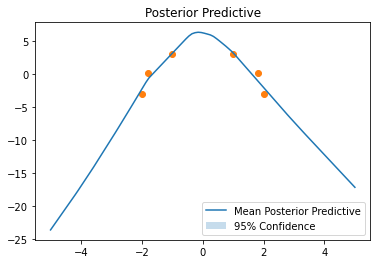

In [ ]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)
samples = 100
x_tmp = jnp.linspace(-5,5,100).reshape(-1,1)
y_samp = jnp.zeros((samples,100))
def forward(x):
  f = BNN_MLP()
  return f(x)
forward_t = hk.transform(forward)

for s in range(samples):
    key, _  = jax.random.split(key, num=2)
    y_tmp = forward_t.apply(params, key, x_tmp)
    y_samp = y_samp.at[s].set(y_tmp.reshape(-1))
plt.plot(x_tmp, jnp.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
print(y_samp)
plt.fill_between(x_tmp.reshape(-1), jnp.percentile(y_samp, 2.5, axis = 0), jnp.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()

In [ ]:
print(y_tmp)

## Ensemble learning for uncertainty estimation

Another way to quantify uncertainty for deep learning models is the ensemble method. In general terms, an ensemble can be considered a learning technique where many models are joined to solve a problem. In deep learning, basically it performs uncertainty approximation by training an ensemble of models independently at the same time and collecting the outputs of different models to get their statistics. 

In [ ]:
# ensemble 
class Ensembles(hk.Module):
    def __init__(self, model_num=10, name=None):
        super().__init__(name=name)
        self.model_num = model_num

    # x is of shape ([ensemble_num, *seqs.shape])
    def __call__(self, x):
        out = jnp.array(
            [
                hk.nets.MLP((32, 1))(x[i])
                for i in range(self.model_num)
            ]
        )
        return out.reshape(10, -1)

def ensemble_forward(x):
  f = Ensembles()
  return f(x)

ensemble_forward_t = hk.transform(ensemble_forward)

def loss(params, forward, features, labels):
  # tile the features and labels
  key = jax.random.PRNGKey(0)
  features_tile = jnp.tile(features, (10, 1, 1))
  labels_tile = jnp.tile(labels, (10, 1))
  predict = forward.apply(params, key, features_tile)
  mse = jnp.mean((predict - labels_tile) ** 2)
  return mse

In [ ]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation, inputs, labels) -> optax.Params:
  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state, inputs, labels):
    loss_value, grads = jax.value_and_grad(loss)(params, ensemble_forward_t, inputs, labels)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for epoch in range(10):
    for i, (input, label) in enumerate(zip(inputs, labels)):
      params, opt_state, loss_value = step(params, opt_state, inputs, labels)
    if epoch % 1 == 0:
      print(f'epoch {epoch}, loss: {loss_value}')

  return params

In [ ]:
params = ensemble_forward_t.init(jax.random.PRNGKey(0), jnp.tile(features, (10, 1, 1))) # initialize params
params = fit(params, optax.adam(learning_rate=1e-1), features[:1024], labels[:1024])

In [ ]:
feature_tile = jnp.tile(features[:1024], (10, 1, 1))
predicts = ensemble_forward_t.apply(params, key, feature_tile)
predicts_mean = jnp.mean(predicts, axis=0)
predicts_std = jnp.std(predicts, axis=0)

(1024,)
(1024,)


<ErrorbarContainer object of 3 artists>

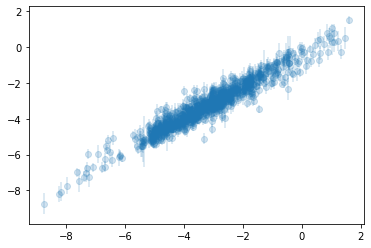

In [64]:
import matplotlib.pyplot as plt
print(predicts_mean.shape)
print(predicts_std.shape)
plt.scatter(labels[:1024], predicts_mean, alpha=0.2)
plt.errorbar(labels[:1024], predicts_mean, predicts_std, alpha=0.2, ls='none')

## Calibration

uncertainty tool-box : https://github.com/uncertainty-toolbox/uncertainty-toolbox